In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

from cgtasknet.instrumetns.dynamic_generate import SNNStates
from cgtasknet.instrumetns.instrument_pca import PCA
from cgtasknet.net.lifadex import SNNlifadex
from cgtasknet.net.states import LIFAdExInitState
from cgtasknet.tasks.tasks import WorkingMemory

In [5]:
number_of_tasks = 8
task_list = [("WorkingMemory", dict()), ("ContextDM", dict())]
tasks = dict(task_list)
params = dict(
    [
        ("dt", 1e-3),  # step 1ms
        ("delay", 0.5),  # 500 ms
        ("trial", 0.5),  # 500 ms
        ("KU", 0.05),  # 50 ms
        ("PB", 0.05),  # 50 ms
        ("min", 0),
        ("max", 1),
        ("first", 0.1),
        ("second", 0.9),
    ]
)

params2 = dict(
    [
        ("dt", 1e-3),  # step 1ms
        ("delay", 0.5),  # 500 ms
        ("trial", 0.5),  # 500 ms
        ("KU", 0.05),  # 50 ms
        ("PB", 0.05),  # 50 ms
        ("min", 0),
        ("max", 1),
        ("first", 0.9),
        ("second", 0.1),
    ]
)
Task = WorkingMemory(params)  # MultyTask(tasks=tasks, batch_size=1)
Task2 = WorkingMemory(params2)
feature_size = 8
output_size = 5
hidden_size = 400
batch_size = 1

In [10]:
model = SNNlifadex(feature_size, hidden_size, output_size)
if True:
    model.load_state_dict(
        torch.load(
            "save_notebooks/saved_models/lif_adex_romo_and_ctx_1510_iterations_steps"
        )
    )

In [25]:
init_state = LIFAdExInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
second_state = init_state.random_state()
one_trajectory_time = 5198
out_mean = torch.zeros((one_trajectory_time, batch_size, output_size))
v_mean = torch.zeros((one_trajectory_time, batch_size, hidden_size))
number_of_trials = 100

In [26]:
for trial in tqdm(range(number_of_trials)):
    inputs, target_out = Task.dataset(1)
    data = np.zeros((inputs.shape[0], batch_size, feature_size))
    data[:, :, 0] = inputs[:, :, 0]
    data[:, :, 2] = 1
    data[:, :, 7] = inputs[:, :, 1]
    data += np.random.normal(0, 0.01, size=(data.shape))
    data = torch.from_numpy(data).type(torch.float32)
    inputs, target_out = Task2.dataset(1)
    data2 = np.zeros((inputs.shape[0], batch_size, feature_size))
    data2[:, :, 0] = inputs[:, :, 0]
    data2[:, :, 2] = 1
    data2[:, :, 7] = inputs[:, :, 1]
    data2 += np.random.normal(0, 0.01, size=(data.shape))
    data2 = torch.from_numpy(data2).type(torch.float32)
    data = torch.concat((data, data2), axis=0)
    states_generator = SNNStates(model)
    out, states = states_generator.states(data, second_state)
    v = []
    s = []
    i = []
    for j in range(len(states)):
        v.append(states[j].v)
        s.append(states[j].z)
        i.append(states[j].i)
    v = torch.stack(v).detach()
    v_mean += v
    out_mean += out
v_mean /= float(number_of_trials)
out /= float(number_of_trials)
pca = PCA(2).decompose(v_mean.reshape(v_mean.shape[0], v_mean.shape[2]))

100%|██████████| 100/100 [08:47<00:00,  5.27s/it]


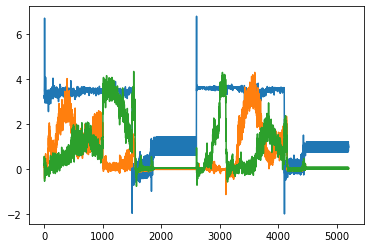

In [22]:
plt.plot(out_mean.detach().cpu().numpy()[:, 0, 0])
plt.plot(out_mean.detach().cpu().numpy()[:, 0, 3])
plt.plot(out_mean.detach().cpu().numpy()[:, 0, 4])

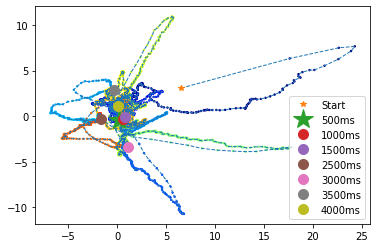

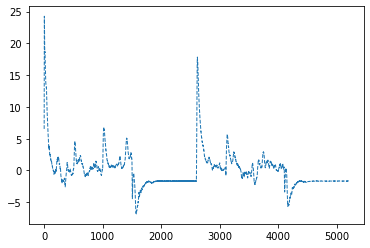

In [24]:
cmap = np.arange(0, len(v_mean))
plt.plot(pca.numpy()[:, 0], pca.numpy()[:, 1], "--", linewidth=1)
plt.scatter(pca.numpy()[:, 0], pca.numpy()[:, 1], c=cmap, cmap="jet", s=2)
plt.plot(pca.numpy()[0, 0], pca.numpy()[0, 1], "*", label="Start")
plt.plot(pca.numpy()[500, 0], pca.numpy()[500, 1], "*", markersize=20, label="500ms")
plt.plot(pca.numpy()[1000, 0], pca.numpy()[1000, 1], "o", markersize=10, label="1000ms")
plt.plot(pca.numpy()[1500, 0], pca.numpy()[1500, 1], "o", markersize=10, label="1500ms")
plt.plot(pca.numpy()[2500, 0], pca.numpy()[2500, 1], "o", markersize=10, label="2500ms")
plt.plot(pca.numpy()[3000, 0], pca.numpy()[3000, 1], "o", markersize=10, label="3000ms")
plt.plot(pca.numpy()[3500, 0], pca.numpy()[3500, 1], "o", markersize=10, label="3500ms")
plt.plot(pca.numpy()[4000, 0], pca.numpy()[4000, 1], "o", markersize=10, label="4000ms")
plt.legend()
plt.show()
plt.plot(pca.numpy()[:, 0], "--", linewidth=1)
plt.show()